# **TF-IDF Analysis for political Leanings**

https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html

https://radimrehurek.com/gensim/models/tfidfmodel.html

https://stackoverflow.com/questions/11911469/tfidf-for-search-queries

https://stackoverflow.com/questions/12118720/python-tf-idf-cosine-to-find-document-similarity/18914884#18914884 

https://scikit-learn.org/stable/auto_examples/text/plot_document_classification_20newsgroups.html#sphx-glr-auto-examples-text-plot-document-classification-20newsgroups-py


https://radimrehurek.com/gensim/models/tfidfmodel.html


#Other tools
https://github.com/williamscott701/Information-Retrieval/blob/master/2.%20TF-IDF%20Ranking%20-%20Cosine%20Similarity%2C%20Matching%20Score/TF-IDF.ipynb

https://github.com/anuragjain-git/text-classification    #Detect spam and others

https://www.geeksforgeeks.org/understanding-tf-idf-term-frequency-inverse-document-frequency/

https://medium.com/product-ai/text-preprocessing-in-python-steps-tools-and-examples-bf025f872908

In [ ]:
# https://scikit-learn.org/stable/auto_examples/text/plot_document_classification_20newsgroups.html#sphx-glr-auto-examples-text-plot-document-classification-20newsgroups-py
# https://scikit-learn.org/stable/auto_examples/text/plot_document_clustering.html#sphx-glr-auto-examples-text-plot-document-clustering-py


from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from collections import Counter
from num2words import num2words

import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from time import time

import re
import contractions
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd


In [ ]:
def preprocess(text):
    # List of editorial names to exclude
    #editorials_to_exclude = ["cnn", "fox", "reuters"]
    
    # Remove the editorial names from the text
    #for editorial in editorials_to_exclude:
        #text = re.sub(r"\b" + re.escape(editorial) + r"\b", "", text, flags=re.IGNORECASE)
    
    text = text.lower()
    text = contractions.fix(text.lower())
    return text


def load_dataset(file_path, text_column, label_column, verbose=False):
    """
    Load and vectorize a dataset for text classification using TF-IDF.

    Parameters:
    - file_path: str, path to the CSV file.
    - text_column: str, name of the column containing the text data.
    - label_column: str, name of the column containing the labels.
    - verbose: bool, if True, prints dataset and vectorization details.

    Returns:
    - X_train: sparse matrix, TF-IDF features for training data.
    - X_test: sparse matrix, TF-IDF features for test data.
    - y_train: array-like, labels for training data.
    - y_test: array-like, labels for test data.
    - feature_names: list, names of the features (tokens).
    - label_names: array-like, unique labels in the dataset.
    """
    # Load dataset
    df = pd.read_csv(file_path)

    # Select relevant columns and handle missing data
    texts = df[text_column].fillna("")  # Fill NaN with empty string
    texts = texts.apply(preprocess)  # Apply preprocessing
    labels = df[label_column]
    
    # Split into training and testing sets
    X_train_texts, X_test_texts, y_train, y_test = train_test_split(
        texts, labels, test_size=0.2, random_state=42, stratify=labels
    )

    # Initialize the TfidfVectorizer
    vectorizer = TfidfVectorizer(
        sublinear_tf=True, 
        max_df=0.5, 
        min_df=5, 
        stop_words="english"
    )

    # Vectorize the training data
    t0 = time()
    X_train = vectorizer.fit_transform(X_train_texts)
    duration_train = time() - t0

    # Vectorize the testing data
    t0 = time()
    X_test = vectorizer.transform(X_test_texts)
    duration_test = time() - t0

    # Get feature names
    feature_names = vectorizer.get_feature_names_out()
    label_names = labels.unique()

    if verbose:
        print(f"Dataset loaded from {file_path}")
        print(f"Total documents: {len(df)}")
        print(f"Training documents: {len(X_train_texts)}")
        print(f"Testing documents: {len(X_test_texts)}")
        print(f"Number of unique labels: {len(label_names)}")
        print(f"TF-IDF vectorization:")
        print(f" - Training data: {X_train.shape}, completed in {duration_train:.2f}s")
        print(f" - Testing data: {X_test.shape}, completed in {duration_test:.2f}s")
        print(f"Number of features (tokens): {len(feature_names)}")

    return X_train, X_test, y_train, y_test, feature_names, label_names


In [ ]:
file_path = "./data/2019_2.csv"
text_column = "body"
#text_column = "headline"
label_column = "political_leaning"

X_train, X_test, y_train, y_test, feature_names, label_names = load_dataset(
    file_path, text_column, label_column, verbose=True
)

Dataset loaded from ./data/2019_2.csv
Total documents: 50269
Training documents: 40215
Testing documents: 10054
Number of unique labels: 4
TF-IDF vectorization:
 - Training data: (40215, 47251), completed in 16.26s
 - Testing data: (10054, 47251), completed in 4.15s
Number of features (tokens): 47251


### *Prediction with Ridge classification*

top 5 keywords per class:
       LEFT      UNDEFINED     CENTER      RIGHT
0   reuters  advertisement        fox      image
1     trump            npr      click  copyright
2      2019           read        app      video
3  usatoday             mr  breitbart        cnn
4       abc         people    percent    caption


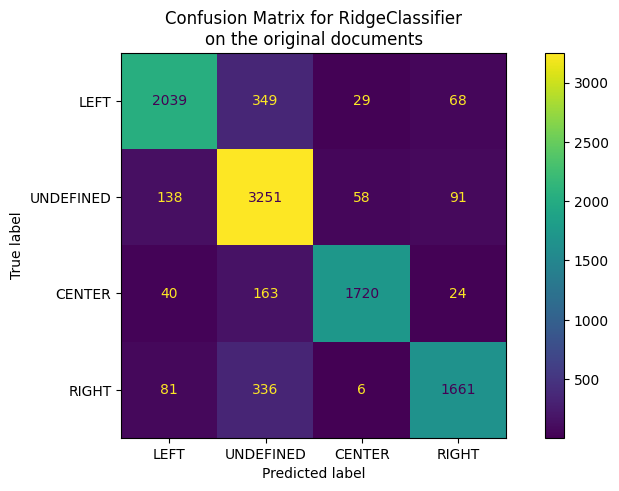

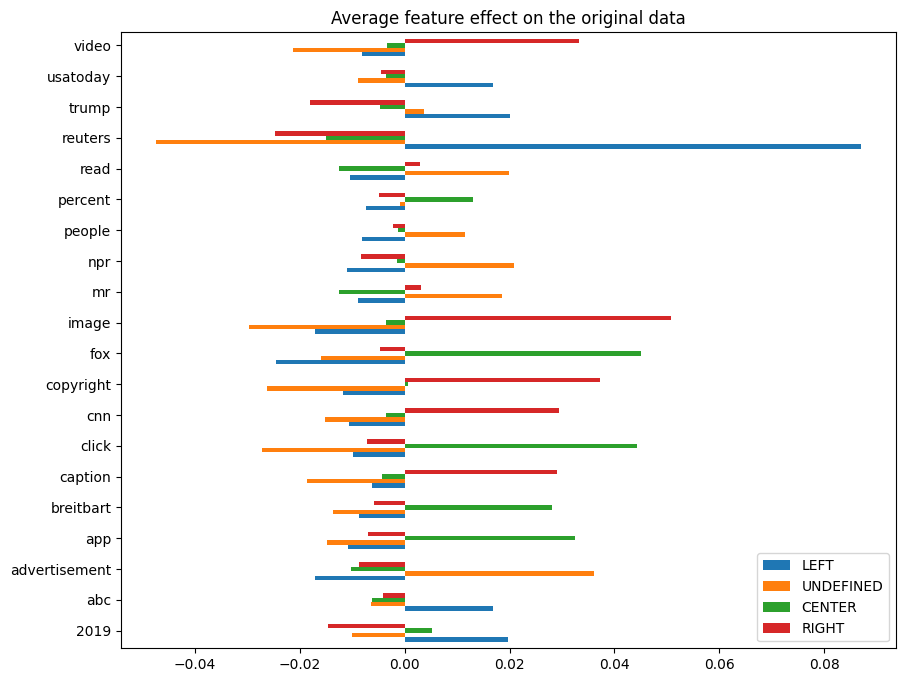

In [23]:
from sklearn.linear_model import RidgeClassifier

clf = RidgeClassifier(tol=1e-2, solver="sparse_cg")
clf.fit(X_train, y_train)
pred = clf.predict(X_test)

target_names = ['LEFT', 'UNDEFINED', 'CENTER', 'RIGHT']


fig, ax = plt.subplots(figsize=(10, 5))
ConfusionMatrixDisplay.from_predictions(y_test, pred, ax=ax)
ax.xaxis.set_ticklabels(target_names)
ax.yaxis.set_ticklabels(target_names)
_ = ax.set_title(
    f"Confusion Matrix for {clf.__class__.__name__}\non the original documents"
)

def plot_feature_effects():
    # learned coefficients weighted by frequency of appearance
    average_feature_effects = clf.coef_ * np.asarray(X_train.mean(axis=0)).ravel()

    for i, label in enumerate(target_names):
        top5 = np.argsort(average_feature_effects[i])[-5:][::-1]
        if i == 0:
            top = pd.DataFrame(feature_names[top5], columns=[label])
            top_indices = top5
        else:
            top[label] = feature_names[top5]
            top_indices = np.concatenate((top_indices, top5), axis=None)
    top_indices = np.unique(top_indices)
    predictive_words = feature_names[top_indices]

    # plot feature effects
    bar_size = 0.25
    padding = 0.75
    y_locs = np.arange(len(top_indices)) * (4 * bar_size + padding)

    fig, ax = plt.subplots(figsize=(10, 8))
    for i, label in enumerate(target_names):
        ax.barh(
            y_locs + (i - 2) * bar_size,
            average_feature_effects[i, top_indices],
            height=bar_size,
            label=label,
        )
    ax.set(
        yticks=y_locs,
        yticklabels=predictive_words,
        ylim=[
            0 - 4 * bar_size,
            len(top_indices) * (4 * bar_size + padding) - 4 * bar_size,
        ],
    )
    ax.legend(loc="lower right")

    print("top 5 keywords per class:")
    print(top)

    return ax


_ = plot_feature_effects().set_title("Average feature effect on the original data")

### *Prediction with Multinomial Naive Bayes*

Top 5 keywords per class:
LEFT: ['reuters' 'trump' 'president' '2019' 'year']
UNDEFINED: ['trump' 'people' 'president' 'new' 'government']
CENTER: ['fox' 'trump' 'news' 'president' 'click']
RIGHT: ['image' 'caption' 'copyright' 'mr' 'police']


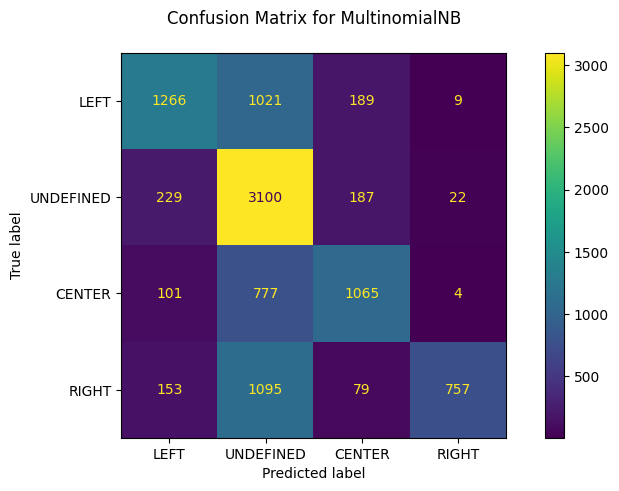

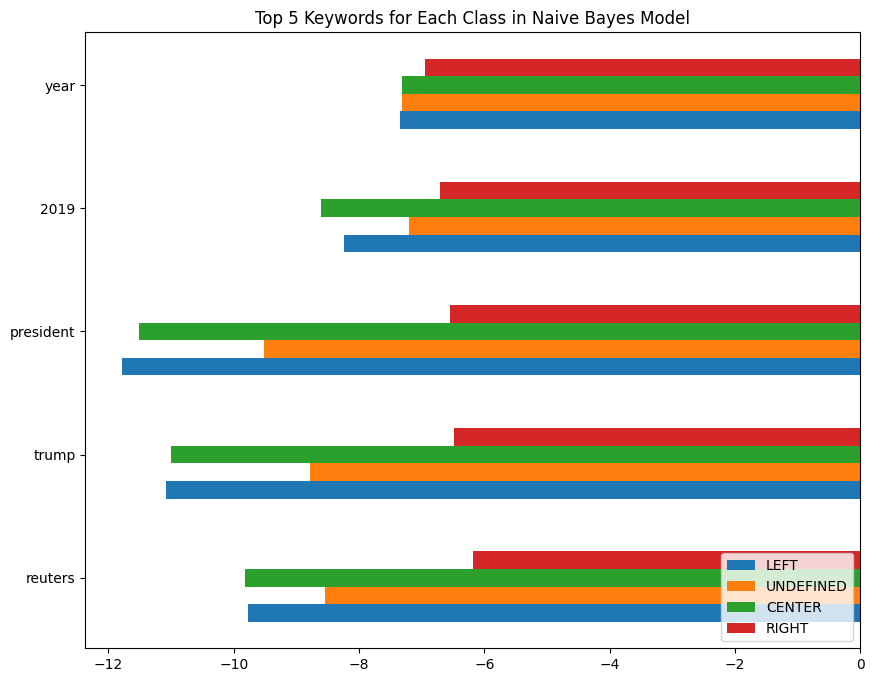

In [46]:
from sklearn.naive_bayes import MultinomialNB

# Train a Naive Bayes model
clf = MultinomialNB(alpha=1.0)  # 'alpha' is the smoothing parameter
clf.fit(X_train, y_train)
pred = clf.predict(X_test)

# Target names (replace with your actual target names)
target_names = ['LEFT', 'UNDEFINED', 'CENTER', 'RIGHT']

# Confusion matrix plot
fig, ax = plt.subplots(figsize=(10, 5))
ConfusionMatrixDisplay.from_predictions(y_test, pred, ax=ax)
ax.xaxis.set_ticklabels(target_names)
ax.yaxis.set_ticklabels(target_names)
_ = ax.set_title(f"Confusion Matrix for {clf.__class__.__name__}\n")

def plot_feature_effects():
    # Get log probabilities for each word in each class (coef_ for Naive Bayes)
    class_log_prob = clf.feature_log_prob_

    # Store the top 5 words for each class
    top_words = {}

    for i, label in enumerate(target_names):
        # Get the top 5 most important words for each class (highest log probability)
        top5_indices = np.argsort(class_log_prob[i])[-5:][::-1]
        top5_words = feature_names[top5_indices]
        top_words[label] = top5_words

    # Plot the top 5 words for each class
    bar_size = 0.25
    padding = 0.75
    y_locs = np.arange(5) * (4 * bar_size + padding)

    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Plot the top words for each class
    for i, label in enumerate(target_names):
        ax.barh(
            y_locs + (i - 2) * bar_size,
            class_log_prob[i, top5_indices],
            height=bar_size,
            label=label,
        )
    
    ax.set(
        yticks=y_locs,
        yticklabels=top_words[target_names[0]],  # Use top 5 words for the first class as y-tick labels
        ylim=[0 - 4 * bar_size, 5 * (4 * bar_size + padding) - 4 * bar_size],
    )
    ax.legend(loc="lower right")

    # Print the top 5 words for each class
    print("Top 5 keywords per class:")
    for label, words in top_words.items():
        print(f"{label}: {words}")
    
    return ax

# Plot the feature effects
_ = plot_feature_effects().set_title("Top 5 Keywords for Each Class in Naive Bayes Model")


### Analysis of different models for prediction

In [36]:
from sklearn import metrics
from sklearn.utils.extmath import density


def benchmark(clf, custom_name=False):
    print("_" * 80)
    print("Training: ")
    print(clf)
    t0 = time()
    clf.fit(X_train, y_train)
    train_time = time() - t0
    print(f"train time: {train_time:.3}s")

    t0 = time()
    pred = clf.predict(X_test)
    test_time = time() - t0
    print(f"test time:  {test_time:.3}s")

    score = metrics.accuracy_score(y_test, pred)
    print(f"accuracy:   {score:.3}")

    if hasattr(clf, "coef_"):
        print(f"dimensionality: {clf.coef_.shape[1]}")
        print(f"density: {density(clf.coef_)}")
        print()

    print()
    if custom_name:
        clf_descr = str(custom_name)
    else:
        clf_descr = clf.__class__.__name__
    return clf_descr, score, train_time, test_time

In [37]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import ComplementNB
from sklearn.neighbors import KNeighborsClassifier, NearestCentroid
from sklearn.svm import LinearSVC

results = []
for clf, name in (
    (LogisticRegression(C=4, max_iter=1000), "Logistic Regression"),
    (RidgeClassifier(alpha=1.0, solver="sparse_cg"), "Ridge Classifier"),
    (KNeighborsClassifier(n_neighbors=100), "kNN"),
    (RandomForestClassifier(), "Random Forest"),
    # L2 penalty Linear SVC
    (LinearSVC(C=0.1, dual=False, max_iter=1000), "Linear SVC"),
    # L2 penalty Linear SGD
    (
        SGDClassifier(
            loss="log_loss", alpha=1e-4, n_iter_no_change=3, early_stopping=True
        ),
        "log-loss SGD",
    ),
    # NearestCentroid (aka Rocchio classifier)
    (NearestCentroid(), "NearestCentroid"),
    # Sparse naive Bayes classifier
    (ComplementNB(alpha=0.1), "Complement naive Bayes"),
):
    print("=" * 80)
    print(name)
    results.append(benchmark(clf, name))

Logistic Regression
________________________________________________________________________________
Training: 
LogisticRegression(C=4, max_iter=1000)
train time: 18.4s
test time:  0.131s
accuracy:   0.861
dimensionality: 47251
density: 1.0


Ridge Classifier
________________________________________________________________________________
Training: 
RidgeClassifier(solver='sparse_cg')
train time: 4.75s
test time:  0.01s
accuracy:   0.862
dimensionality: 47251
density: 1.0


kNN
________________________________________________________________________________
Training: 
KNeighborsClassifier(n_neighbors=100)
train time: 0.053s
test time:  42.3s
accuracy:   0.65

Random Forest
________________________________________________________________________________
Training: 
RandomForestClassifier()
train time: 2.29e+02s
test time:  0.843s
accuracy:   0.836

Linear SVC
________________________________________________________________________________
Training: 
LinearSVC(C=0.1, dual=False)
train tim

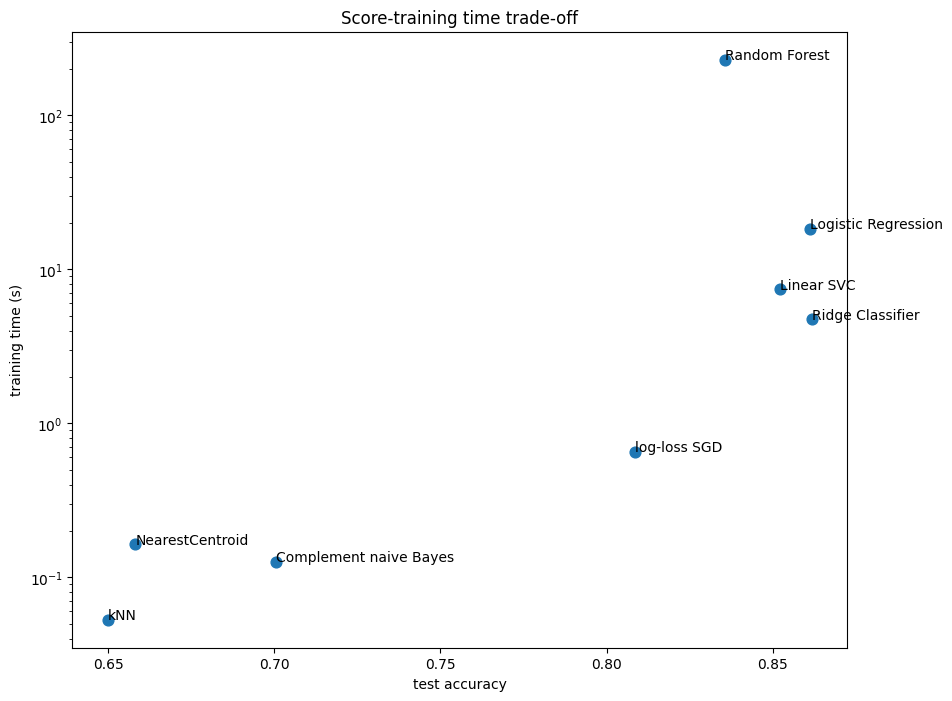

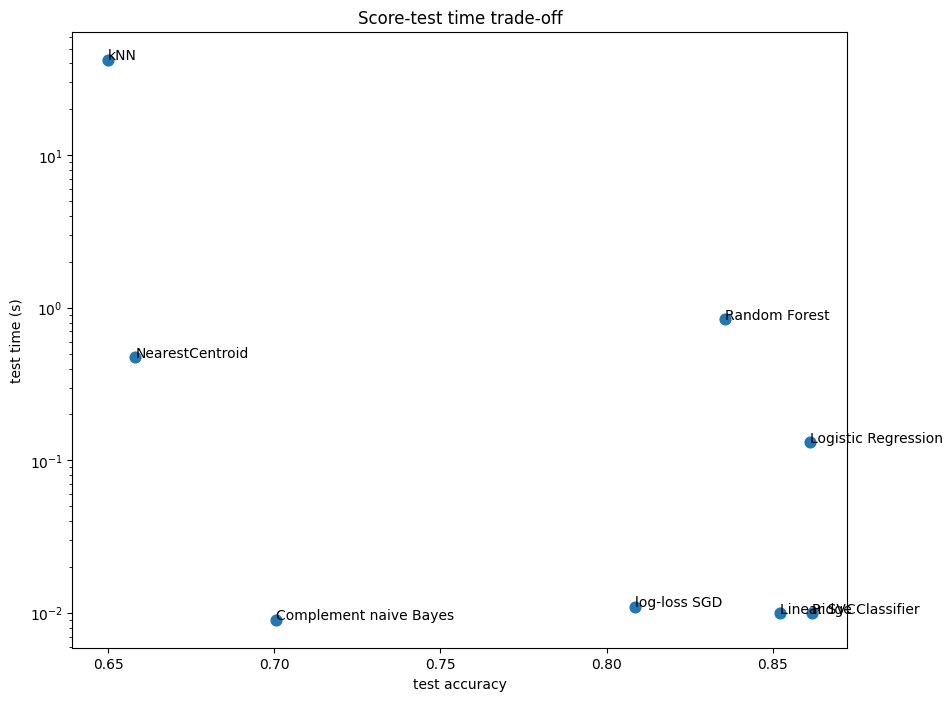

In [38]:
indices = np.arange(len(results))

results = [[x[i] for x in results] for i in range(4)]

clf_names, score, training_time, test_time = results
training_time = np.array(training_time)
test_time = np.array(test_time)

fig, ax1 = plt.subplots(figsize=(10, 8))
ax1.scatter(score, training_time, s=60)
ax1.set(
    title="Score-training time trade-off",
    yscale="log",
    xlabel="test accuracy",
    ylabel="training time (s)",
)
fig, ax2 = plt.subplots(figsize=(10, 8))
ax2.scatter(score, test_time, s=60)
ax2.set(
    title="Score-test time trade-off",
    yscale="log",
    xlabel="test accuracy",
    ylabel="test time (s)",
)

for i, txt in enumerate(clf_names):
    ax1.annotate(txt, (score[i], training_time[i]))
    ax2.annotate(txt, (score[i], test_time[i]))

### *Prediction with XgBoost*

In [8]:

import xgboost as xgb

# Encode labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Initialize the XGBoost classifier with GPU support
clf = xgb.XGBClassifier(
    tree_method='gpu_hist',  # Use GPU for training
    predictor='gpu_predictor',  # Use GPU for inference
    eval_metric='mlogloss', 
    objective='multi:softmax',  # Classification task
    n_estimators=100, 
    max_depth=18,       
    learning_rate=0.1,
    random_state=42
)

# Train the classifier
clf.fit(X_train, y_train_encoded)

# Predict on the test set
pred_encoded = clf.predict(X_test)

# Decode predictions back to original labels
pred = label_encoder.inverse_transform(pred_encoded)

c:\Users\ALEJANDRO\Documents\7. DUKE\1. ECE 684 - NLP\Assignments\Final Project\venv_lda_implementation\Lib\site-packages\xgboost\core.py:158: UserWarning: [11:26:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\ALEJANDRO\Documents\7. DUKE\1. ECE 684 - NLP\Assignments\Final Project\venv_lda_implementation\Lib\site-packages\xgboost\core.py:158: UserWarning: [11:26:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\ALEJANDRO\Documents\7. DUKE\1. ECE 684 - NLP\Assignments\Final Project\venv_lda

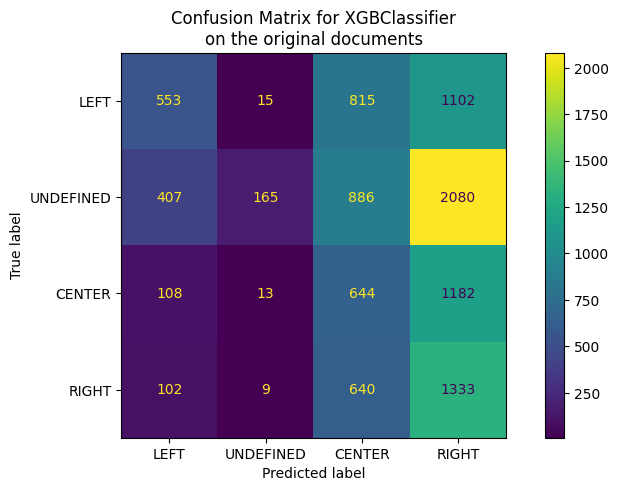

In [9]:
import matplotlib.pyplot as plt

from sklearn.metrics import ConfusionMatrixDisplay

target_names = ['LEFT', 'UNDEFINED', 'CENTER', 'RIGHT']

fig, ax = plt.subplots(figsize=(10, 5))
ConfusionMatrixDisplay.from_predictions(y_test, pred, ax=ax)
ax.xaxis.set_ticklabels(target_names)
ax.yaxis.set_ticklabels(target_names)
_ = ax.set_title(
    f"Confusion Matrix for {clf.__class__.__name__}\non the original documents"
)

### *Prediction with Random forests*

In [40]:
from sklearn.ensemble import RandomForestClassifier

# Encode labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Initialize the Random Forest classifier
clf = RandomForestClassifier(
    n_estimators=100,  # Number of trees
    max_depth=10,      # Maximum depth of each tree (adjust as needed)
    random_state=42    # Ensures reproducibility
)

# Train the classifier
clf.fit(X_train, y_train_encoded)

# Predict on the test set
pred_encoded = clf.predict(X_test)

# Decode predictions back to original labels
pred = label_encoder.inverse_transform(pred_encoded)

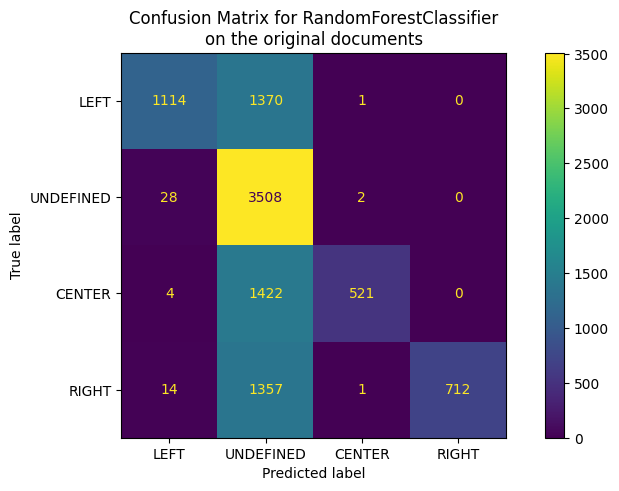

In [41]:
import matplotlib.pyplot as plt

from sklearn.metrics import ConfusionMatrixDisplay

target_names = ['LEFT', 'UNDEFINED', 'CENTER', 'RIGHT']

fig, ax = plt.subplots(figsize=(10, 5))
ConfusionMatrixDisplay.from_predictions(y_test, pred, ax=ax)
ax.xaxis.set_ticklabels(target_names)
ax.yaxis.set_ticklabels(target_names)
_ = ax.set_title(
    f"Confusion Matrix for {clf.__class__.__name__}\non the original documents"
)

### Feature importance in corpus

Top 20 important features:
        Feature  Importance
0         image    0.029374
1     copyright    0.027687
2       reuters    0.027226
3     breitbart    0.025631
4           fox    0.024002
5         photo    0.022013
6           app    0.018251
7         click    0.014907
8          2019    0.012893
9            mr    0.011027
10  unsupported    0.009862
11          bbc    0.009376
12     politico    0.009148
13         news    0.008797
14         file    0.008776
15        story    0.008393
16          www    0.008319
17        share    0.008215
18           07    0.007947
19          npr    0.007779


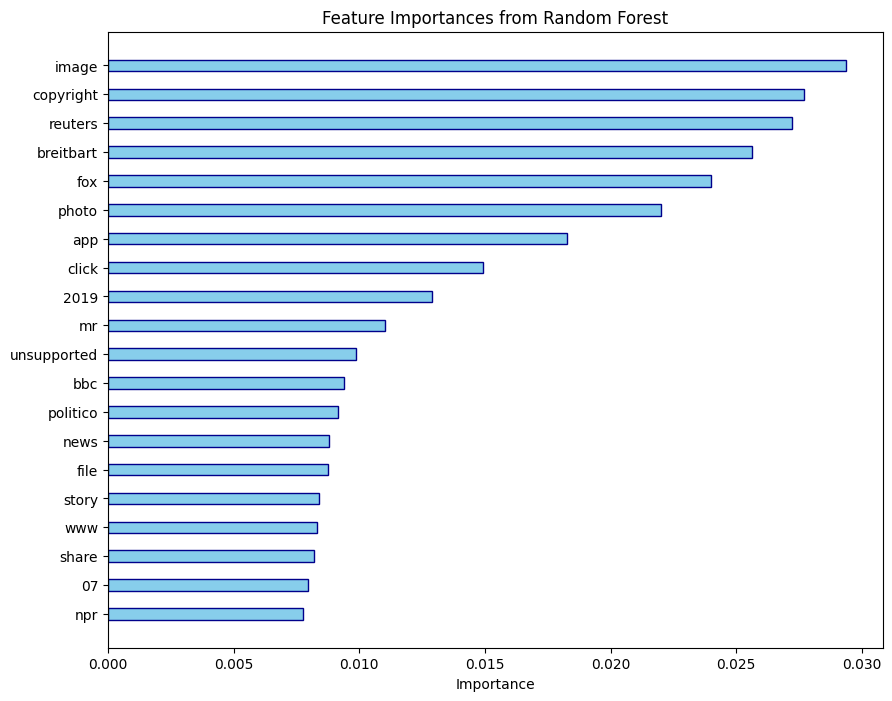

In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance

# Define the function to plot feature importances
def plot_feature_effects_rf():
    # Ensure clf has been trained and feature_importances_ is not empty
    if not hasattr(clf, 'feature_importances_'):
        raise ValueError("The classifier has not been trained yet.")
    
    feature_importances = clf.feature_importances_

    # Check if feature_importances contains valid values
    if np.all(feature_importances == 0):
        print("Warning: All feature importances are zero. Check the training data and model.")
        return None

    # Get the indices of the top 20 features by importance
    top_indices = np.argsort(feature_importances)[-20:][::-1]  # Sort by importance, descending

    # Get the top 20 features and their importances
    top_features = pd.DataFrame({
        "Feature": feature_names[top_indices],  # Use the feature names from the vectorizer
        "Importance": feature_importances[top_indices]
    })

    # Print the top features for reference
    print("Top 20 important features:")
    print(top_features)

    # Plot feature importances
    bar_size = 0.4
    fig, ax = plt.subplots(figsize=(10, 8))
    y_locs = np.arange(len(top_indices))

    ax.barh(
        y_locs,
        top_features["Importance"],
        color="skyblue",
        edgecolor="darkblue",
        height=bar_size,
    )
    ax.set_yticks(y_locs)
    ax.set_yticklabels(top_features["Feature"])
    ax.invert_yaxis()  # Most important features on top
    ax.set_xlabel("Importance")
    ax.set_title("Top 20 Feature Importances (Random Forest)")

    return ax

_ = plot_feature_effects_rf().set_title("Feature Importances from Random Forest")
#    _ = plot_class_specific_feature_effects(clf, X_train, y_train, feature_names)


### Metadata stripping

In [ ]:
(
    X_train,
    X_test,
    y_train,
    y_test,
    feature_names,
    target_names,
) = load_dataset(remove=("headers", "footers", "quotes"))

clf = RidgeClassifier(tol=1e-2, solver="sparse_cg")
clf.fit(X_train, y_train)
pred = clf.predict(X_test)

fig, ax = plt.subplots(figsize=(10, 5))
ConfusionMatrixDisplay.from_predictions(y_test, pred, ax=ax)
ax.xaxis.set_ticklabels(target_names)
ax.yaxis.set_ticklabels(target_names)
_ = ax.set_title(
    f"Confusion Matrix for {clf.__class__.__name__}\non filtered documents"
)